# Tutorial for post-processing of building fraction impacts to estimate human displacement

In this code, we apply the concept of displacement following a particular level of building damage post impact calculation. Meaning, we first calculate building fraction damages for each event and store the resulting impact matrices. On this basis, we can postprocess the results and convert thresholds of buildling-fraction damage to displaced population.

This approach stands in contrast to applying the building threshold prior to the impact calculation on the level of the impact functions.

Here, we explore this approach for tropical cyclones in the Philippines.

In [1]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

# modify path!!! adapt path to where you save the "global-displacement-risk" repository
os.chdir('/Users/simonameiler/Documents/work/03_code/repos/global-displacement-risk')
 
import exposure
import vulnerability
import coastal_flood_hazard
import impact_postproc

# select country here
cntry = 'PHL'

### Load exposure
for more details refer to the [exposure tutorial](tutorial_exposure.ipynb)

In [2]:
# load bem
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>1] # filter out rows with basically no population

In [3]:
# assign admin-1
gdf_bem_subcomps = exposure.assign_admin1_attr(gdf_bem_subcomps, exposure.path_admin1_attrs, source='gadm')

In [4]:
# make exposure
exp = Exposures(gdf_bem_subcomps.copy())
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf['value'] = 1 # each building type gets value 1
exp.gdf = exp.gdf[~np.isnan(exp.gdf.latitude)]  # drop nan centroids    
exp.gdf = exp.gdf[~np.isnan(exp.gdf.admin1)]  # drop nan admin1

Add impact function ID to exposure gdf. Impact functions from PAGER are mapped to the structural building classes from the BEM.

In [5]:
exp.gdf['impf_TC'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_TCIMPF_CAPRA)

In [6]:
exp.gdf.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry,admin1,longitude,latitude,value,impf_TC
0,177569777,PHL,3,edu_priv,W,2.328791,0.008799,56.098,43.902,0.0,POINT (119.99583 16.32917),2391.0,119.995833,16.329167,1,8
1,177569777,PHL,3,edu_priv,UFB,5.012018,0.018936,56.098,43.902,0.0,POINT (119.99583 16.32917),2391.0,119.995833,16.329167,1,36
2,177569777,PHL,3,edu_priv,RS,1.817976,0.006869,56.098,43.902,0.0,POINT (119.99583 16.32917),2391.0,119.995833,16.329167,1,50
3,177569777,PHL,3,edu_priv,INF,4.338522,0.016392,56.098,43.902,0.0,POINT (119.99583 16.32917),2391.0,119.995833,16.329167,1,17
4,177569777,PHL,3,edu_priv,A,9.930804,0.037520,56.098,43.902,0.0,POINT (119.99583 16.32917),2391.0,119.995833,16.329167,1,9


/Users/simonameiler/Documents/WCR/CLIMADA_develop/climada_python/climada/util/coordinates.py:2415: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_poly['geometry'] = apply_box(points_df)


<GeoAxes: >

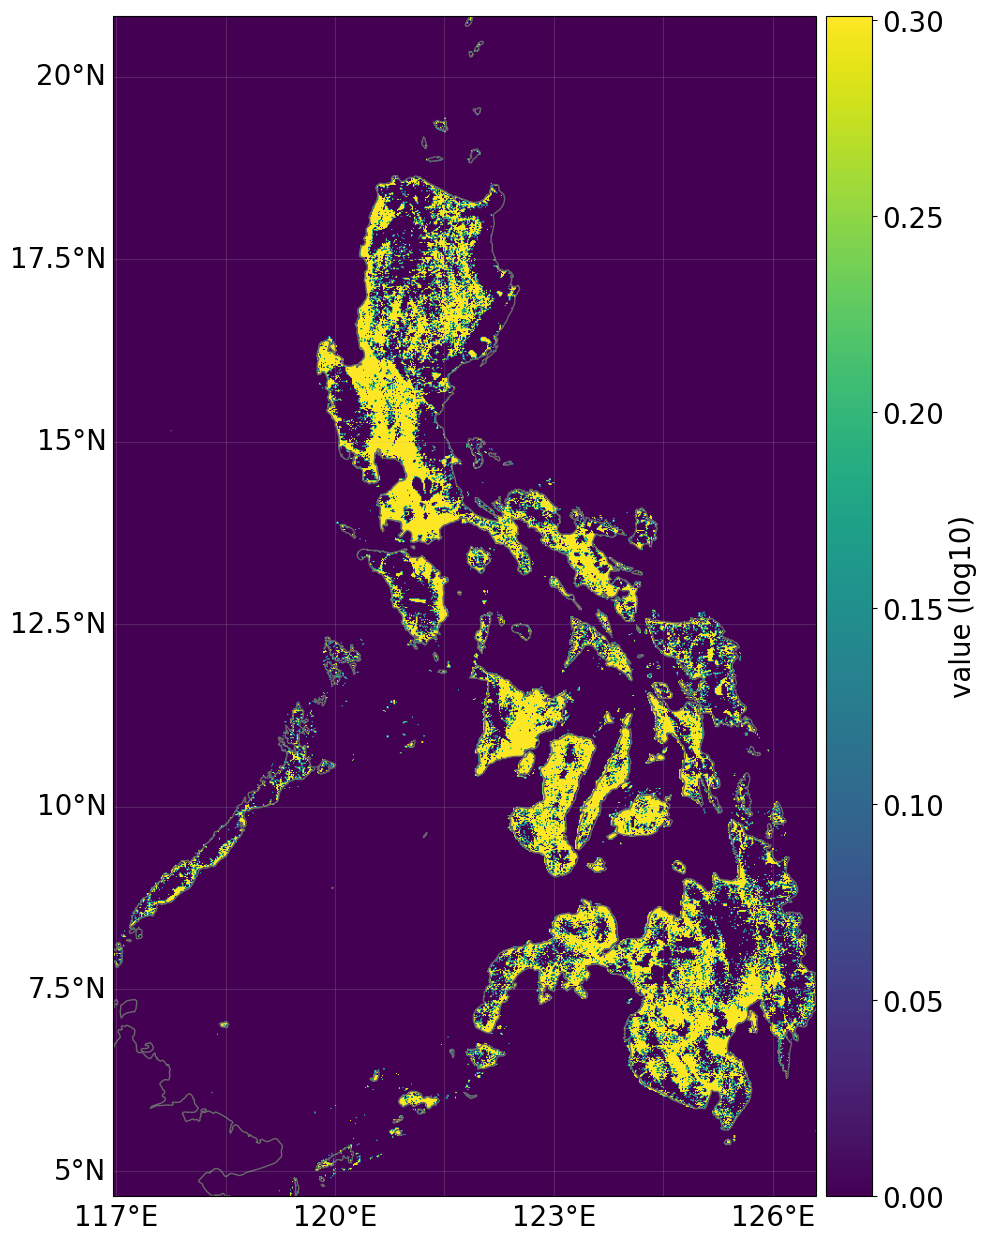

In [7]:
exp.plot_raster()

### Load tropical cyclone hazard

In [8]:
hazard_dir = SYSTEM_DIR/"hazard"/"present"
tc_haz = TropCyclone.from_hdf5(hazard_dir.joinpath(f'TC_WP_0150as_MIT_H08.hdf5'))

Get latitude, longitude limits from the exposure to limit the hazard set accordingly

In [9]:
lat_min, lat_max, lon_min, lon_max = exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max()

In [10]:
# crop hazard
tc_haz_PHL = tc_haz.select(extent=(lon_min, lon_max, lat_min, lat_max))

<GeoAxes: title={'center': 'TC max intensity at each point'}>

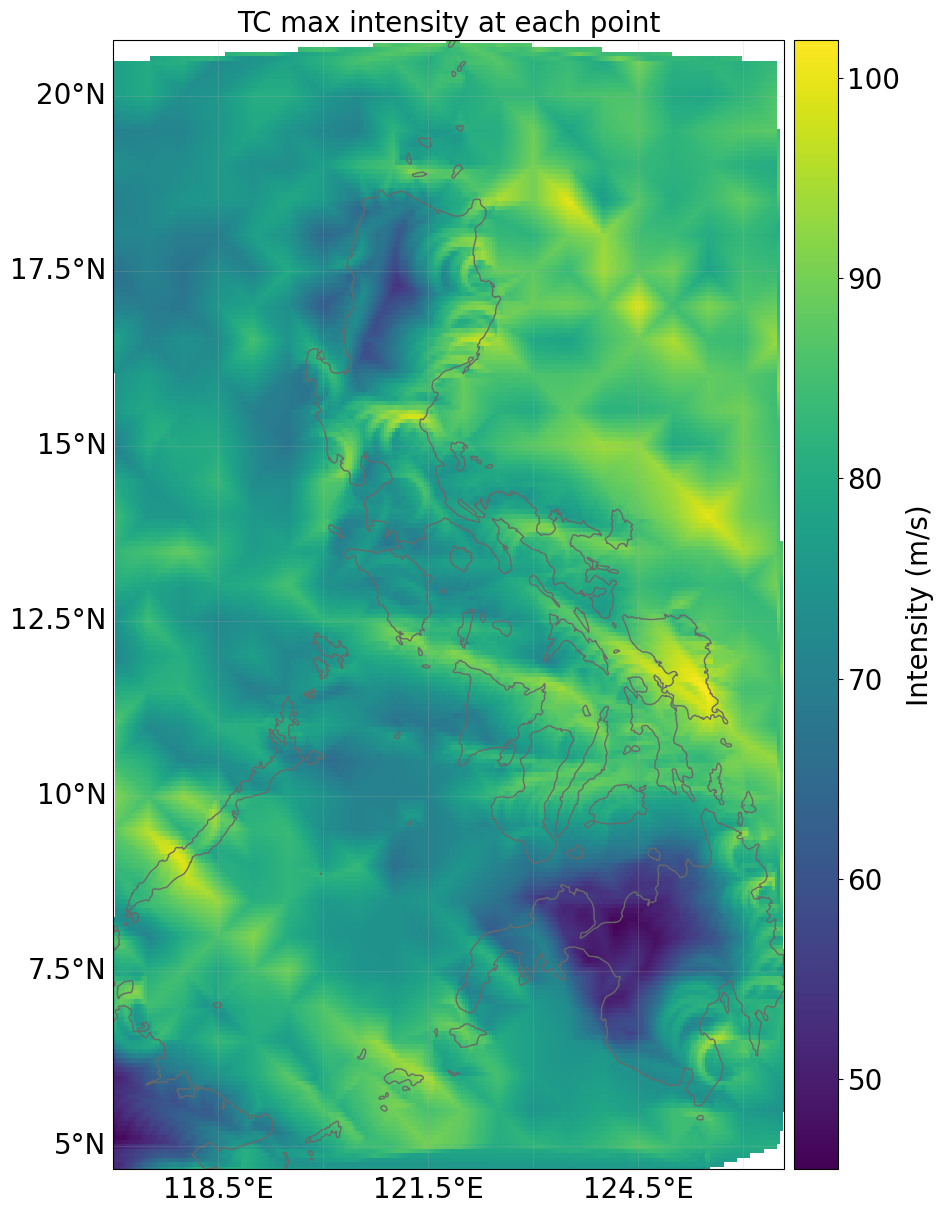

In [11]:
tc_haz_PHL.plot_intensity(0)

### Calculate displacement impact

In [12]:
# compute damage fractions on buildings; save impact matrix
impact_bldg = ImpactCalc(exp, vulnerability.IMPF_SET_TC_CAPRA, tc_haz_PHL).impact(save_mat=True)

In [13]:
# do a quick sanity check
print('max dmg:', impact_bldg.imp_mat.data.max(), 'min dmg:', impact_bldg.imp_mat.data.min())

max dmg: 0.9027328018611736 min dmg: 5.688509640845354e-12


# This is where the impact post-processing begins

**First simple approach:**

Use different building damage thresholds uniformly over the entire country to simulate human displacement as a consequence from a given building damage threshold.

In [14]:
# set displacement-damage threshold(s) - this could be informed by RISK INFORM or other indices!!!
dmg_thresh_low = 0.30
dmg_thresh_med = 0.55 # the default threshold in the global displacement risk model
dmg_thresh_high = 0.70

In [15]:
# decide on whether threshold reached for all scenarios
displ_low = impact_bldg.imp_mat > dmg_thresh_low
displ_med = impact_bldg.imp_mat > dmg_thresh_med
displ_high = impact_bldg.imp_mat > dmg_thresh_high

In [16]:
displ_med

<20500x6602591 sparse matrix of type '<class 'numpy.bool_'>'
	with 7205623 stored elements in Compressed Sparse Row format>

**Idea: calculate the aai_agg from the impact matrix using the CLIMADA logic of aai_agg = sum(impact.at_event x frequency)**

i) create diagonal matrix from TC.frequency vector  
ii) multiply boolean impact matrix with it  
iii) sum remaining entries up  

In [17]:
from scipy.sparse import csr_matrix

freq_diagonal_matrix = csr_matrix(np.diag(tc_haz_PHL.frequency))

In [18]:
imp_bldg_frac = freq_diagonal_matrix @ displ_med

In [19]:
imp_bldg_frac

<20500x6602591 sparse matrix of type '<class 'numpy.float64'>'
	with 7205623 stored elements in Compressed Sparse Row format>

In [20]:
print('max dmg:', imp_bldg_frac.data.max(), 'min dmg:', imp_bldg_frac.data.min())

max dmg: 0.0008573947804878048 min dmg: 0.0002934953658536585


In [21]:
imp_bldg_frac.sum()
print(f"Total Building Fraction Damage: {imp_bldg_frac.sum():,.0f}")

Total Building Fraction Damage: 4,174


**Next: convert building fraction damage to displaced population**

i) multiply building fraction impact matrix (imp_bldg_frac) with the exposure gdf "valhum" value   
ii) sum up for population aai_agg 

In [22]:
imp_pop_total = sum(imp_bldg_frac * exp.gdf.valhum)

In [23]:
imp_pop_total
print(f"Annual Average Displacement PHL: {imp_pop_total:,.0f}")

Annual Average Displacement PHL: 104,317


or, iii) save the spatially explicit results of expected annual displacement at each location as sparse matrix

In [24]:
imp_pop = csr_matrix(imp_bldg_frac * exp.gdf.valhum)

#### Plot results

Replace the imp_mat of the original impact object with the newly generated sparse matrix of displaced population and plot the result.

In [25]:
# replacing impact matrix
import copy as cp
imp_pop_PHL = cp.deepcopy(impact_bldg)
imp_pop_PHL.imp_mat = imp_pop

##### Annual Average Displacement

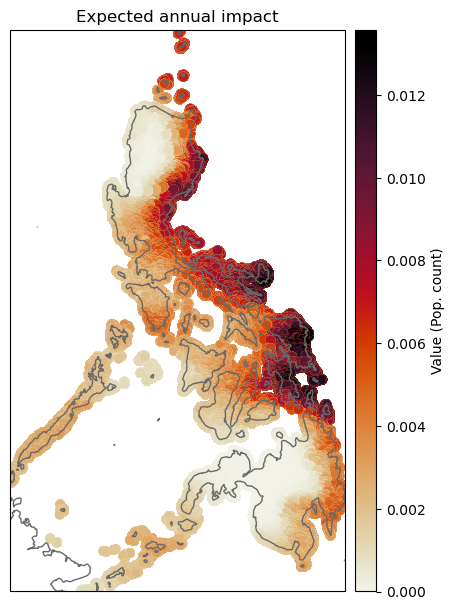

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

imp_pop_PHL.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

### Suggested next steps:

* Find a threshold that best matches displacement estimates for the Philippines
* Define spatially varying thresholds dependent on sub-national indices:
    * Instead of comparing the sparse matrix impact_bldg.imp_mat to scalar thresholds as shown in the tutorial above, you can perform element-wise comparisons with another sparse matrix representing thresholds.
    * For example, you could use the exposure admin1 level to define thresholds for each admin1 region
    * Or if you find a spatially explicit vulnerability index, you could map this to your exposure/impact grid and create a sparse matrix from there.